# 🧠 Task 2 – Quantitative Sentiment–Price Analysis  
📘 Version: 2025-06-01  

This notebook initiates exploratory and quantitative analysis of stock price movements in relation to sentiment signals extracted from financial news.  
It supports the computation of technical indicators, return alignment, and visual diagnostics.

---

### This notebook covers:
- Modular loading of historical stock price data  
- Basic technical indicator computation using TA-Lib  
- Alignment of stock data with enriched sentiment signals  
- Preparation for downstream correlation analysis


In [1]:
# 🗂️ Project Directory Setup

#To ensure smooth path handling across environments, we standardize the working directory and define data locations relative to the project root.

#- **Sentiment Dataset**: `data/cleaned_headlines_sample.csv`
#- **Stock Price Data**: `data/yfinance_data/*.csv`

#All modules are assumed to be accessible from the `src/` folder when running the notebook from the root.

# 🛠 Standardize working directory
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print("📂 Working directory is now:", os.getcwd())

# 🔎 Confirm required sentiment and price files exist
sentiment_file = "data/cleaned_headlines_sample.csv"
price_dir = "data/yfinance_data"
expected_tickers = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA", "TSLA"]

# Check sentiment file
print("📄 Sentiment file found ✅" if os.path.exists(sentiment_file) else f"❌ Sentiment file missing: {sentiment_file}")

# Check stock price files
for ticker in expected_tickers:
    price_path = os.path.join(price_dir, f"{ticker}_historical_data.csv")
    status = "✅" if os.path.exists(price_path) else "❌"
    print(f"{status} {ticker} data file: {price_path}")


📂 Working directory is now: c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge
📄 Sentiment file found ✅
✅ AAPL data file: data/yfinance_data\AAPL_historical_data.csv
✅ AMZN data file: data/yfinance_data\AMZN_historical_data.csv
✅ GOOG data file: data/yfinance_data\GOOG_historical_data.csv
✅ META data file: data/yfinance_data\META_historical_data.csv
✅ MSFT data file: data/yfinance_data\MSFT_historical_data.csv
✅ NVDA data file: data/yfinance_data\NVDA_historical_data.csv
✅ TSLA data file: data/yfinance_data\TSLA_historical_data.csv


In [2]:
# ------------------------------------------------------------------------------
# 📦 Core Libraries
# ------------------------------------------------------------------------------
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# 📈 Financial Analysis & Signal Tools
# ------------------------------------------------------------------------------
# TA-Lib for technical indicators (MACD, RSI, etc.)
import talib

# For future NLP-driven sentiment joins
from rapidfuzz import fuzz, process  # Optional: for fuzzy ticker/event joins

# ------------------------------------------------------------------------------
# 🔧 Display & Notebook Config
# ------------------------------------------------------------------------------
from IPython.display import display

# ------------------------------------------------------------------------------
# 🛠️ Module Reloading for Dev Iteration
# ------------------------------------------------------------------------------
import importlib
import src.price_data_loader
import src.news_loader

importlib.reload(src.price_data_loader)
importlib.reload(src.news_loader)

from src.price_data_loader import PriceDataLoader
from src.news_loader import NewsDataLoader

# ------------------------------------------------------------------------------
# 📋 Display Settings
# ------------------------------------------------------------------------------
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
sns.set(style="whitegrid")

In [3]:
# ------------------------------------------------------------------------------
# 📥 Load Stock Price Data & Enriched News Sentiment Dataset
# ------------------------------------------------------------------------------

from src.price_data_loader import PriceDataLoader
from src.news_loader import NewsDataLoader  # ✅ Reuse Task 1 loader

# Define paths to stock price directory and sentiment CSV file
PRICE_DATA_DIR = "data/yfinance_data"
SENTIMENT_DATA_PATH = "data/cleaned_headlines_sample.csv"

# Initialize and load all stock price CSVs in the directory
try:
    price_loader = PriceDataLoader(
        folder_path=PRICE_DATA_DIR, verbose=True
    )  # ✅ Correct param
    prices_df = price_loader.load_all()
    print("✅ All stock price files loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load stock price data: {e}")
    prices_df = None  # gracefully degrade

# Initialize and load the enriched sentiment dataset
try:
    sentiment_loader = NewsDataLoader(
        path=SENTIMENT_DATA_PATH, parse_dates=["cleaned_date"], verbose=True
    )
    sentiment_df = sentiment_loader.load()
    print("✅ Enriched sentiment dataset loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load sentiment dataset: {e}")
    sentiment_df = None  # gracefully degrade


📄 Loaded: AAPL | Path: data/yfinance_data\AAPL_historical_data.csv
📦 Encoding used: utf-8
🔢 Rows: 10,998 | Columns: 10
🗓️ Date range: 1980-12-12 → 2024-07-30
🧪 Columns: Date, Open, High, Low, Close, Adj Close, Volume, Dividends, Stock Splits, cleaned_date


📄 Loaded: AMZN | Path: data/yfinance_data\AMZN_historical_data.csv
📦 Encoding used: utf-8
🔢 Rows: 6,846 | Columns: 10
🗓️ Date range: 1997-05-15 → 2024-07-30
🧪 Columns: Date, Open, High, Low, Close, Adj Close, Volume, Dividends, Stock Splits, cleaned_date


📄 Loaded: GOOG | Path: data/yfinance_data\GOOG_historical_data.csv
📦 Encoding used: utf-8
🔢 Rows: 5,020 | Columns: 10
🗓️ Date range: 2004-08-19 → 2024-07-30
🧪 Columns: Date, Open, High, Low, Close, Adj Close, Volume, Dividends, Stock Splits, cleaned_date


📄 Loaded: META | Path: data/yfinance_data\META_historical_data.csv
📦 Encoding used: utf-8
🔢 Rows: 2,926 | Columns: 10
🗓️ Date range: 2012-12-12 → 2024-07-30
🧪 Columns: Date, Open, High, Low, Close, Adj Close, Volume, Dividends,

## ✅ Initial Sanity Checks – Structure, Missingness, Duplicates

Before diving into analysis, we run a quick diagnostic to verify data health:

- Preview the top 3 rows for structural validation.
- Print full column data types to confirm schema expectations.
- Check for missing values across all columns.
- Identify and count any fully duplicated rows.

These checks help detect formatting issues or corrupt entries early, ensuring downstream feature engineering operates on clean and consistent data.


In [4]:
# ------------------------------------------------------------------------------
# ✅ Initial Sanity Check – Stock Price and Sentiment Datasets
# ------------------------------------------------------------------------------


def run_sanity_check(df, name="DataFrame"):
    """
    Runs basic data quality checks on a given DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to check.
    name : str
        A label for the dataset (used in printouts).
    """
    print(f"\n🧪 Sanity Check – {name}")
    print("-" * 60)

    if df is not None:
        # Show preview
        display(df.head(3))

        # Column types
        print("🧬 Column Data Types:")
        print(df.dtypes)

        # Nulls
        print("\n🔍 Missing Value Summary:")
        missing = df.isna().sum()
        print(
            missing[missing > 0] if missing.any() else "✅ No missing values detected."
        )

        # Duplicates
        duplicate_count = df.duplicated().sum()
        if duplicate_count > 0:
            print(f"⚠️ Found {duplicate_count:,} duplicate rows.")
        else:
            print("✅ No duplicate rows found.")
    else:
        print(f"🚫 Skipping {name} – DataFrame not loaded.")


# Run checks for both datasets
run_sanity_check(prices_df, name="Stock Price Data")
run_sanity_check(sentiment_df, name="Enriched Sentiment Data")


🧪 Sanity Check – Stock Price Data
------------------------------------------------------------


,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,cleaned_date,ticker
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0,1980-12-12,AAPL
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0,1980-12-15,AAPL
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0,1980-12-16,AAPL


🧬 Column Data Types:
Date                    object
Open                   float64
High                   float64
Low                    float64
Close                  float64
Adj Close              float64
Volume                   int64
Dividends              float64
Stock Splits           float64
cleaned_date    datetime64[ns]
ticker                  object
dtype: object

🔍 Missing Value Summary:
✅ No missing values detected.
✅ No duplicate rows found.

🧪 Sanity Check – Enriched Sentiment Data
------------------------------------------------------------


,Unnamed: 0,headline,url,publisher,date,stock,cleaned_date,cleaned_headline,headline_length,word_count,publisher_domain,date_only,hour,day_of_week,is_weekend,bullish_flag,bearish_flag,vader_scores,vader_compound,vader_sentiment,textblob_polarity,ensemble_sentiment,ensemble_confidence
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,2020-06-05,stocks hit 52week highs friday,39,7,benzinga.com,2020-06-04,20,Thursday,False,True,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neutral,0.0,neutral,0.5
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,2020-06-03,stocks hit 52week highs wednesday,42,7,benzinga.com,2020-06-02,20,Tuesday,False,True,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neutral,0.0,neutral,0.5
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,2020-05-26,71 biggest movers friday,29,5,benzinga.com,2020-05-25,20,Monday,False,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neutral,0.0,neutral,0.5


🧬 Column Data Types:
Unnamed: 0                      int64
headline                       object
url                            object
publisher                      object
date                           object
stock                          object
cleaned_date           datetime64[ns]
cleaned_headline               object
headline_length                 int64
word_count                      int64
publisher_domain               object
date_only                      object
hour                            int64
day_of_week                    object
is_weekend                       bool
bullish_flag                     bool
bearish_flag                     bool
vader_scores                   object
vader_compound                float64
vader_sentiment                object
textblob_polarity             float64
ensemble_sentiment             object
ensemble_confidence           float64
dtype: object

🔍 Missing Value Summary:
cleaned_headline    2
dtype: int64
✅ No duplicate rows found.


# 🔗 Sentiment–Price Signal Alignment

This section performs a robust alignment between financial news sentiment signals and historical stock price data. The alignment pipeline includes:

### 🧮 Key Logic:

- **Sentiment Encoding**:  
  Converts `ensemble_sentiment` (“bullish”, “neutral”, “bearish”) into a numerical `sentiment_score` in the range [-1, 0, 1].

- **Exponential Time Decay**:  
  If multiple headlines occur on the same day for a given ticker, their `sentiment_score` values are collapsed into a single `weighted_sentiment` using an exponential decay function. The decay factor (λ) determines how sharply older headlines are down-weighted.

- **Return Computation**:  
  For each ticker and date, we compute:  
  - `return_t`: the day-over-day percentage change in the `Close` price.  
  - `forward_return_1d`: the 1-day forward return (`Close.shift(-1)/Close – 1`).  
  - `forward_return_3d` and `forward_return_5d`: similarly calculated 3-day and 5-day forward returns.

- **Volume Signals**:  
  - `volume_return_t`: the day-over-day percentage change in `Volume`.  
  - `volume_7d_avg`: the 7-day rolling average of `Volume`.  
  - `volume_spike`: a binary flag (1/0) set to 1 if today’s `Volume` > 1.5 × `volume_7d_avg`.  
  - `sentiment_volume_divergence`:  
    - `"bullish_low_vol"` if `weighted_sentiment > 0` and `volume_return_t < 0`.  
    - `"bearish_high_vol"` if `weighted_sentiment < 0` and `volume_return_t > 0`.  
    - `"aligned"` otherwise.

- **Lagged Features** (added after alignment):  
  - `sentiment_lag_1d`, `sentiment_lag_3d`, `sentiment_lag_5d` (previous 1, 3, 5 days’ `weighted_sentiment`)  
  - `return_lag_1d`, `return_lag_3d` (previous 1, 3 days’ `return_t`)

- **Final Merge**:  
  - Merge the decayed‐sentiment DataFrame with the OHLCV price DataFrame on `["ticker", "cleaned_date"]`.  
  - Drop any rows missing critical columns (`weighted_sentiment`, `return_t`, `forward_return_1d`) so downstream models only see valid data.

### 📦 Output:

A merged DataFrame with columns including:  
- **Identifiers**:  
  - `ticker`, `cleaned_date`
- **Price/Volume**:  
  - `Open`, `High`, `Low`, `Close`, `Volume`, (and any other OHLCV fields)
- **Sentiment**:  
  - `weighted_sentiment`  
  - `sentiment_lag_1d`, `sentiment_lag_3d`, `sentiment_lag_5d`
- **Returns**:  
  - `return_t`, `forward_return_1d`, `forward_return_3d`, `forward_return_5d`  
  - `return_lag_1d`, `return_lag_3d`
- **Volume Signals**:  
  - `volume_return_t`, `volume_7d_avg`, `volume_spike`  
  - `sentiment_volume_divergence`

This enriched DataFrame is ready for correlation analysis, signal evaluation, or predictive modeling in Task 3.```


In [5]:
# ------------------------------------------------------------------------------
# 🔗 Align Sentiment with Price Data Using SentimentReturnAligner
# ------------------------------------------------------------------------------

import pandas as pd  # pandas for DataFrame operations
from src.sentiment_return_aligner import SentimentReturnAligner  # aligner class

try:
    # 1) Verify that sentiment_df and prices_df exist and have the correct columns
    print("🔍 Verifying DataFrame schemas…")
    print("   Sentiment DF columns:", sentiment_df.columns.tolist())  # list sentiment_df columns
    print("   Prices DF columns:   ", prices_df.columns.tolist())  # list prices_df columns

    # === STEP A: Initial deduplication of raw prices_df columns =========================
    dup_prices_initial = prices_df.columns[prices_df.columns.duplicated()].tolist()  # find duplicated column names
    if dup_prices_initial:
        print("⚠️ Duplicate columns found in raw prices_df:", dup_prices_initial)  # warn about duplicates
        prices_df = prices_df.loc[:, ~prices_df.columns.duplicated()].copy()  # drop all but first of each duplicate
        print(
            "   → After initial deduplication, prices_df columns:",
            prices_df.columns.tolist(),
        )  # show new column list
    # ======================================================================================

    # 2) Rename columns so they match the aligner’s requirements
    #    sentiment_df must have ['ticker','cleaned_date','ensemble_sentiment']
    #    prices_df    must have ['ticker','cleaned_date','Close','Volume']

    # 2a) If "stock" exists in sentiment_df, rename it to "ticker"
    if "stock" in sentiment_df.columns:
        sentiment_df.rename(columns={"stock": "ticker"}, inplace=True)

    # 2b) On prices_df: drop existing "Close" before renaming "Adj Close → Close"
    if "Adj Close" in prices_df.columns:
        if "Close" in prices_df.columns:
            prices_df.drop(columns=["Close"], inplace=True)  # remove old "Close" to avoid duplication
        prices_df.rename(columns={"Adj Close": "Close"}, inplace=True)  # rename "Adj Close"

    # 2c) On prices_df: drop existing "cleaned_date" before renaming "Date → cleaned_date"
    if "Date" in prices_df.columns:
        if "cleaned_date" in prices_df.columns:
            prices_df.drop(columns=["cleaned_date"], inplace=True)  # remove old "cleaned_date"
        prices_df.rename(columns={"Date": "cleaned_date"}, inplace=True)  # rename "Date"

    # 3) Rename any mismatched tickers in sentiment_df so they match prices_df
    #    e.g., 'MFT' → 'MSFT', 'FB' → 'META'
    sentiment_df["ticker"] = sentiment_df["ticker"].replace(
        {"MFT": "MSFT", "FB": "META"}
    )  # map any old ticker symbols to new ones
    print(
        "🔄 After ticker fixes, unique tickers in sentiment_df:",
        sorted(sentiment_df["ticker"].unique()),
    )  # preview unique tickers

    # === STEP B: Ensure consistent dtypes & ticker formatting ============================
    sentiment_df["ticker"] = (
        sentiment_df["ticker"].astype(str).str.strip().str.upper()
    )  # force ticker to uppercase string without whitespace
    prices_df["ticker"] = prices_df["ticker"].astype(str).str.strip().str.upper()  # same for prices_df

    sentiment_df["cleaned_date"] = pd.to_datetime(
        sentiment_df["cleaned_date"], errors="coerce"
    ).dt.normalize()  # convert to datetime and normalize (midnight)
    prices_df["cleaned_date"] = pd.to_datetime(
        prices_df["cleaned_date"], errors="coerce"
    ).dt.normalize()  # convert to datetime and normalize

    print("✔️ Date/ticker normalization complete.")
    print(
        "   Sentiment date range:",
        sentiment_df["cleaned_date"].min(),
        "→",
        sentiment_df["cleaned_date"].max(),
    )  # show sentiment date min/max
    print(
        "   Prices    date range:",
        prices_df["cleaned_date"].min(),
        "→",
        prices_df["cleaned_date"].max(),
    )  # show prices date min/max
    # ======================================================================================

    # === STEP C: Final deduplication AFTER all renaming ================================
    dup_prices_final = prices_df.columns[prices_df.columns.duplicated()].tolist()  # find duplicates post-rename
    if dup_prices_final:
        print(
            "⚠️ Duplicate columns found in prices_df after renaming:", dup_prices_final
        )  # warn about duplicates
        prices_df = prices_df.loc[:, ~prices_df.columns.duplicated()].copy()  # drop duplicates
        print(
            "   → After final deduplication, prices_df columns:",
            prices_df.columns.tolist(),
        )  # show updated columns

    dup_sentiment_final = sentiment_df.columns[
        sentiment_df.columns.duplicated()
    ].tolist()  # find duplicates in sentiment_df
    if dup_sentiment_final:
        print(
            "⚠️ Duplicate columns found in sentiment_df after cleanup:",
            dup_sentiment_final,
        )  # warn if any
        sentiment_df = sentiment_df.loc[:, ~sentiment_df.columns.duplicated()].copy()  # drop them
        print(
            "   → After final deduplication, sentiment_df columns:",
            sentiment_df.columns.tolist(),
        )  # show new columns
    # ======================================================================================

    # 4) Confirm required columns exist before alignment
    required_sentiment_cols = {"ticker", "cleaned_date", "ensemble_sentiment"}  # must have these in sentiment_df
    missing_sentiment = required_sentiment_cols - set(sentiment_df.columns)  # check for any that are missing
    if missing_sentiment:
        raise KeyError(f"sentiment_df is missing required columns: {missing_sentiment}")

    required_price_cols = {"ticker", "cleaned_date", "Close", "Volume"}  # must have these in prices_df
    missing_price = required_price_cols - set(prices_df.columns)  # check for missing
    if missing_price:
        raise KeyError(f"prices_df is missing required columns: {missing_price}")

    # 5) Instantiate the aligner with OOP parameters
    aligner = SentimentReturnAligner(
        sentiment_df=sentiment_df,  # pass cleaned sentiment DataFrame
        price_df=prices_df,          # pass cleaned price DataFrame
        decay_lambda=0.7,            # set decay parameter
        verbose=True,                # enable verbose logging
        use_tqdm=False,              # disable progress bar
    )

    # 6) Run the alignment pipeline to produce a merged, enriched DataFrame
    aligned_df = aligner.align()  # perform the alignment

    # 7) Display a preview of the final aligned dataset
    print("\n✅ Alignment succeeded. Preview of `aligned_df`:")
    display(aligned_df.head(5))  # show first 5 rows
    print("🔍 aligned_df shape:", aligned_df.shape)  # show dimensions

    # === STEP D: Drop “Orphan” aligned rows (no matching price date) =======================
    merged_keys = prices_df[["ticker", "cleaned_date"]].drop_duplicates()  # valid ticker/date combinations
    valid_aligned = aligned_df.merge(
        merged_keys,
        on=["ticker", "cleaned_date"],
        how="inner",  # keep only rows that match a price date
    )
    dropped_count = aligned_df.shape[0] - valid_aligned.shape[0]  # count how many were dropped
    print(f"➤ Dropped {dropped_count} aligned rows without matching price data.")

    aligned_df = valid_aligned.copy()  # overwrite aligned_df with filtered version
    print("\n✅ Filtered aligned_df preview:")
    display(aligned_df.head(5))  # show first 5 rows of filtered aligned_df
    print("🔍 filtered aligned_df shape:", aligned_df.shape)  # show dimensions
    # ======================================================================================

    # 8) Add lagged features on the filtered aligned DataFrame
    final_df = aligner.add_lagged_features(aligned_df)  # compute lagged features
    print("\n📊 Lagged features added. Preview of `final_df`:")
    display(final_df.head(5))  # show first 5 rows of final_df
    print("🔍 final_df shape:", final_df.shape)  # show dimensions of final_df

except Exception as e:
    # If anything fails, print diagnostic information
    print(f"\n❌ Alignment or lagging failed: {type(e).__name__} – {e}")
    print("→ sentiment_df columns:", sentiment_df.columns.tolist())  # list sentiment_df columns
    print("→ prices_df   columns:", prices_df.columns.tolist())    # list prices_df columns
    if "cleaned_date" in sentiment_df.columns:
        print(
            "→ Sentiment date range:",
            sentiment_df["cleaned_date"].min(),
            "to",
            sentiment_df["cleaned_date"].max(),
        )
    if "cleaned_date" in prices_df.columns:
        print(
            "→ Price date range:",
            prices_df["cleaned_date"].min(),
            "to",
            prices_df["cleaned_date"].max(),
        )
    aligned_df = None  # ensure aligned_df is defined
    final_df = None  # ensure final_df is defined


🔍 Verifying DataFrame schemas…
   Sentiment DF columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'cleaned_date', 'cleaned_headline', 'headline_length', 'word_count', 'publisher_domain', 'date_only', 'hour', 'day_of_week', 'is_weekend', 'bullish_flag', 'bearish_flag', 'vader_scores', 'vader_compound', 'vader_sentiment', 'textblob_polarity', 'ensemble_sentiment', 'ensemble_confidence']
   Prices DF columns:    ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'cleaned_date', 'ticker']
🔄 After ticker fixes, unique tickers in sentiment_df: ['A', 'AA', 'AAC', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAU', 'AAV', 'AAVL', 'AAWW', 'AAXJ', 'AB', 'ABAC', 'ABAX', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABCO', 'ABCW', 'ABDC', 'ABEV', 'ABG', 'ABGB', 'ABIO', 'ABM', 'ABMD', 'ABR', 'ABTL', 'ABX', 'ABY', 'ACAD', 'ACAS', 'ACAT', 'ACC', 'ACCO', 'ACCU', 'ACE', 'ACET', 'ACFC', 'ACFN', 'ACG', 'ACGL', 'ACH', 'ACHC',

,cleaned_date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,weighted_sentiment,return_t,forward_return_1d,forward_return_3d,forward_return_5d,volume_return_t,volume_7d_avg,volume_spike,sentiment_volume_divergence
0,2020-03-10,69.285004,71.610001,67.342499,69.398438,285290000,0.0,0.0,AAPL,0.125000,0.072022,-0.034731,-0.025829,-0.113829,-0.005074,2.860174e+08,0,bullish_low_vol
1,2020-03-11,69.347504,70.305000,67.964996,66.988190,255598800,0.0,0.0,AAPL,0.285714,-0.034731,-0.098755,-0.120611,-0.104418,-0.104074,2.758779e+08,0,bullish_low_vol
2,2020-03-12,63.985001,67.500000,62.000000,60.372791,418474000,0.0,0.0,AAPL,0.000000,-0.098755,0.119808,0.018652,-0.013898,0.637230,3.115269e+08,0,aligned
3,2020-03-13,66.222504,69.980003,63.237499,67.605965,370732000,0.0,0.0,AAPL,0.000000,0.119808,-0.128647,-0.112602,-0.175307,-0.114086,3.233679e+08,0,aligned
4,2020-03-16,60.487499,64.769997,60.000000,58.908657,322423600,0.0,0.0,AAPL,0.181818,-0.128647,0.043970,0.010611,-0.073655,-0.130305,3.232105e+08,0,bullish_low_vol


🔍 aligned_df shape: (1870, 18)
➤ Dropped 0 aligned rows without matching price data.

✅ Filtered aligned_df preview:


,cleaned_date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,weighted_sentiment,return_t,forward_return_1d,forward_return_3d,forward_return_5d,volume_return_t,volume_7d_avg,volume_spike,sentiment_volume_divergence
0,2020-03-10,69.285004,71.610001,67.342499,69.398438,285290000,0.0,0.0,AAPL,0.125000,0.072022,-0.034731,-0.025829,-0.113829,-0.005074,2.860174e+08,0,bullish_low_vol
1,2020-03-11,69.347504,70.305000,67.964996,66.988190,255598800,0.0,0.0,AAPL,0.285714,-0.034731,-0.098755,-0.120611,-0.104418,-0.104074,2.758779e+08,0,bullish_low_vol
2,2020-03-12,63.985001,67.500000,62.000000,60.372791,418474000,0.0,0.0,AAPL,0.000000,-0.098755,0.119808,0.018652,-0.013898,0.637230,3.115269e+08,0,aligned
3,2020-03-13,66.222504,69.980003,63.237499,67.605965,370732000,0.0,0.0,AAPL,0.000000,0.119808,-0.128647,-0.112602,-0.175307,-0.114086,3.233679e+08,0,aligned
4,2020-03-16,60.487499,64.769997,60.000000,58.908657,322423600,0.0,0.0,AAPL,0.181818,-0.128647,0.043970,0.010611,-0.073655,-0.130305,3.232105e+08,0,bullish_low_vol


🔍 filtered aligned_df shape: (1870, 18)
📊 Added lagged features: sentiment_lag_(1,3,5)d and return_lag_(1,3)d.

📊 Lagged features added. Preview of `final_df`:


,cleaned_date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,weighted_sentiment,return_t,forward_return_1d,forward_return_3d,forward_return_5d,volume_return_t,volume_7d_avg,volume_spike,sentiment_volume_divergence,sentiment_lag_1d,sentiment_lag_3d,sentiment_lag_5d,return_lag_1d,return_lag_3d
0,2020-03-10,69.285004,71.610001,67.342499,69.398438,285290000,0.0,0.0,AAPL,0.125000,0.072022,-0.034731,-0.025829,-0.113829,-0.005074,2.860174e+08,0,bullish_low_vol,NaN,NaN,NaN,NaN,NaN
1,2020-03-11,69.347504,70.305000,67.964996,66.988190,255598800,0.0,0.0,AAPL,0.285714,-0.034731,-0.098755,-0.120611,-0.104418,-0.104074,2.758779e+08,0,bullish_low_vol,0.125000,NaN,NaN,0.072022,NaN
2,2020-03-12,63.985001,67.500000,62.000000,60.372791,418474000,0.0,0.0,AAPL,0.000000,-0.098755,0.119808,0.018652,-0.013898,0.637230,3.115269e+08,0,aligned,0.285714,NaN,NaN,-0.034731,NaN
3,2020-03-13,66.222504,69.980003,63.237499,67.605965,370732000,0.0,0.0,AAPL,0.000000,0.119808,-0.128647,-0.112602,-0.175307,-0.114086,3.233679e+08,0,aligned,0.000000,0.125000,NaN,-0.098755,0.072022
4,2020-03-16,60.487499,64.769997,60.000000,58.908657,322423600,0.0,0.0,AAPL,0.181818,-0.128647,0.043970,0.010611,-0.073655,-0.130305,3.232105e+08,0,bullish_low_vol,0.000000,0.285714,NaN,0.119808,-0.034731


🔍 final_df shape: (1870, 23)


------------------------------------------------------------------------------
📐 Technical Indicators – SMA, EMA, RSI, MACD, ATR
------------------------------------------------------------------------------

We enrich the sentiment–return aligned dataset with a core suite of technical indicators computed using **TA-Lib**, one of the most widely adopted libraries in quantitative finance.

### Indicators Added:
- **SMA (14-day)** – *Simple Moving Average*: Smooths closing prices over a 14-day window to reveal the prevailing price trend and filter out short-term noise.
  
- **EMA (14-day)** – *Exponential Moving Average*: Similar to SMA but gives greater weight to more recent prices, making it more responsive to momentum shifts and price reversals.
  
- **RSI (14-day)** – *Relative Strength Index*: A bounded oscillator (0–100) that quantifies recent gains versus losses. Typically used to detect overbought (≥70) or oversold (≤30) market conditions.
  
- **MACD & MACD_signal** – *Moving Average Convergence Divergence*: Captures momentum by computing the difference between the 12-day and 26-day EMAs. The **MACD_signal** is a 9-day EMA of the MACD line and is used to trigger cross-over signals.

- **ATR (14-day)** – *Average True Range*: Measures market volatility by averaging the daily true range (defined as the greatest of: high–low, high–previous close, low–previous close) over a 14-day horizon.

---

These indicators jointly capture:
- **Trend direction** (SMA, EMA),
- **Momentum strength and reversals** (RSI, MACD),
- **Volatility regimes** (ATR).

They form a robust technical feature set for downstream correlation diagnostics, divergence detection, and predictive modeling.


In [21]:
# ─────────────────────────────────────────────────────────────────────────────
# 🧮 Compute Technical Indicators & Hybrid Performance Metrics on “Full History” and “Aligned-Only” Frames
# ─────────────────────────────────────────────────────────────────────────────

import pandas as pd  # For DataFrame operations

# Import our indicator calculator and the hybrid performance calculator that uses PyNance.stderr if available
from src.technical_indicator_calculator import (
    TechnicalIndicatorCalculator,
    PyNancePerformanceCalculatorHybrid,
)

# Step 1: Validate input DataFrames
if not isinstance(aligned_df, pd.DataFrame) or not isinstance(prices_df, pd.DataFrame):
    raise TypeError("❌ Both aligned_df and prices_df must be pandas DataFrames")

print("Step 1: aligned_df type →", type(aligned_df))
print("Step 2: prices_df   type →", type(prices_df))

# Step 2: Drop duplicate columns
aligned_df = aligned_df.loc[:, ~aligned_df.columns.duplicated()].copy()
prices_df = prices_df.loc[:, ~prices_df.columns.duplicated()].copy()

# Step 3: Check for required columns
required_price_cols = {"ticker", "cleaned_date", "High", "Low", "Close", "Volume"}
required_aligned_cols = {"ticker", "cleaned_date"}

if missing := required_price_cols - set(prices_df.columns):
    raise KeyError(f"prices_df is missing required columns: {missing}")
if missing := required_aligned_cols - set(aligned_df.columns):
    raise KeyError(f"aligned_df is missing required columns: {missing}")

# Step 4: Compute technical indicators on full price history
full_calc = TechnicalIndicatorCalculator(
    df=prices_df,
    ticker_col="ticker",
    date_col="cleaned_date",
    verbose=True,
    use_tqdm=True,
)
indicators_full = full_calc.add_indicators()
print("✅ indicators_full type →", type(indicators_full))
display(indicators_full.head(3))

# Step 5: Compute hybrid performance metrics per ticker
try:
    perf_calc = PyNancePerformanceCalculatorHybrid(
        df=indicators_full[["ticker", "cleaned_date", "Close"]].copy(),
        verbose=True,
    )
    performance_summary = perf_calc.compute_summary()
    print("\n✅ Hybrid performance summary:")
    display(performance_summary)
except ImportError as ie:
    print(f"⚠️ Skipping hybrid performance metrics: {ie}")
    performance_summary = pd.DataFrame()
except Exception as e:
    print(f"⚠️ Error computing hybrid performance metrics: {type(e).__name__} – {e}")
    performance_summary = pd.DataFrame()

# Step 5b: Merge performance summary into full and aligned enriched DataFrames
if not performance_summary.empty:
    enriched_perf = performance_summary.reset_index()
else:
    enriched_perf = pd.DataFrame(
        columns=[
            "ticker",
            "annualized_return",
            "annualized_volatility",
            "sharpe_ratio",
            "max_drawdown",
        ]
    )

# Step 6: Merge indicators onto full price DataFrame
enriched_full_df = pd.merge(
    prices_df,
    indicators_full,
    on=["ticker", "cleaned_date"],
    how="left",
    validate="one_to_one",
)
enriched_full_df = pd.merge(
    enriched_full_df,
    enriched_perf,
    on="ticker",
    how="left",
    validate="many_to_one",
)
print("\nStep 6: enriched_full_df type →", type(enriched_full_df))
print("         enriched_full_df shape →", enriched_full_df.shape)

# Step 7: Merge indicators onto aligned sentiment DataFrame
enriched_aligned_df = pd.merge(
    aligned_df,
    indicators_full,
    on=["ticker", "cleaned_date"],
    how="left",
    validate="many_to_one",
)
enriched_aligned_df = pd.merge(
    enriched_aligned_df,
    enriched_perf,
    on="ticker",
    how="left",
    validate="many_to_one",
)
print("\nStep 7: enriched_aligned_df type →", type(enriched_aligned_df))
print("         enriched_aligned_df shape →", enriched_aligned_df.shape)
print("         Columns in enriched_aligned_df →", list(enriched_aligned_df.columns))

# Step 8: Check for missing values in indicator columns
indicator_cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "MACD_signal", "ATR_14"]
print("\nStep 8: Null counts in enriched_aligned_df indicator columns:")
for col in indicator_cols:
    if col not in enriched_aligned_df.columns:
        print(f"  ❌ Column '{col}' not found in enriched_aligned_df")
    else:
        print(f"  → {col}: {enriched_aligned_df[col].isna().sum():,} missing values")

# Step 9: Preview both enriched DataFrames
print("\n✅ enriched_full_df (every trading day + indicators) preview:")
display(enriched_full_df.head(3))
print("\n✅ enriched_aligned_df (aligned dates only + indicators) preview:")
display(enriched_aligned_df.head(3))

Step 1: aligned_df type → <class 'pandas.core.frame.DataFrame'>
Step 2: prices_df   type → <class 'pandas.core.frame.DataFrame'>
✅ TechnicalIndicatorCalculator initialized. Required columns present, no duplicates.


Calculating TA indicators:   0%|          | 0/7 [00:00<?, ?ticker/s]

📈 Processing ticker: AAPL
📈 Processing ticker: AMZN
📈 Processing ticker: GOOG
📈 Processing ticker: META
📈 Processing ticker: MSFT
📈 Processing ticker: NVDA


Calculating TA indicators: 100%|██████████| 7/7 [00:00<00:00, 31.18ticker/s]

📈 Processing ticker: TSLA
✅ Technical indicators added for 7 tickers. Final shape: (45428, 15)
✅ indicators_full type → <class 'pandas.core.frame.DataFrame'>


,cleaned_date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,SMA_14,EMA_14,RSI_14,MACD,MACD_signal,ATR_14
0,1980-12-12,0.128348,0.128906,0.128348,0.098943,469033600,0.0,0.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-12-15,0.122210,0.122210,0.121652,0.093781,175884800,0.0,0.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-12-16,0.113281,0.113281,0.112723,0.086898,105728000,0.0,0.0,AAPL,NaN,NaN,NaN,NaN,NaN,NaN


ℹ️ 'daily_return' not found; computing from 'Close' per ticker.
✅ PyNancePerformanceCalculatorHybrid initialized.
✅ Hybrid performance summary computed for 7 tickers.

✅ Hybrid performance summary:


,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
ticker,,,,
AAPL,0.192959,0.442750,0.435820,-0.818014
AMZN,0.319209,0.562379,0.567605,-0.944042
GOOG,0.236688,0.306637,0.771883,-0.652948
META,0.275244,0.385320,0.714327,-0.767361
MSFT,0.259652,0.334987,0.775111,-0.693862
NVDA,0.364664,0.601030,0.606731,-0.897224
TSLA,0.420727,0.569360,0.738947,-0.736322



Step 6: enriched_full_df type → <class 'pandas.core.frame.DataFrame'>
         enriched_full_df shape → (45428, 26)

Step 7: enriched_aligned_df type → <class 'pandas.core.frame.DataFrame'>
         enriched_aligned_df shape → (1870, 35)
         Columns in enriched_aligned_df → ['cleaned_date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Dividends_x', 'Stock Splits_x', 'ticker', 'weighted_sentiment', 'return_t', 'forward_return_1d', 'forward_return_3d', 'forward_return_5d', 'volume_return_t', 'volume_7d_avg', 'volume_spike', 'sentiment_volume_divergence', 'Open_y', 'High_y', 'Low_y', 'Close_y', 'Volume_y', 'Dividends_y', 'Stock Splits_y', 'SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'MACD_signal', 'ATR_14', 'annualized_return', 'annualized_volatility', 'sharpe_ratio', 'max_drawdown']

Step 8: Null counts in enriched_aligned_df indicator columns:
  → SMA_14: 0 missing values
  → EMA_14: 0 missing values
  → RSI_14: 0 missing values
  → MACD: 0 missing values
  → MACD_signal: 0 missi

,cleaned_date,Open_x,High_x,Low_x,Close_x,Volume_x,Dividends_x,Stock Splits_x,ticker,Open_y,High_y,Low_y,Close_y,Volume_y,Dividends_y,Stock Splits_y,SMA_14,EMA_14,RSI_14,MACD,MACD_signal,ATR_14,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
0,1980-12-12,0.128348,0.128906,0.128348,0.098943,469033600,0.0,0.0,AAPL,0.128348,0.128906,0.128348,0.098943,469033600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.192959,0.44275,0.43582,-0.818014
1,1980-12-15,0.122210,0.122210,0.121652,0.093781,175884800,0.0,0.0,AAPL,0.122210,0.122210,0.121652,0.093781,175884800,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.192959,0.44275,0.43582,-0.818014
2,1980-12-16,0.113281,0.113281,0.112723,0.086898,105728000,0.0,0.0,AAPL,0.113281,0.113281,0.112723,0.086898,105728000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.192959,0.44275,0.43582,-0.818014



✅ enriched_aligned_df (aligned dates only + indicators) preview:


,cleaned_date,Open_x,High_x,Low_x,Close_x,Volume_x,Dividends_x,Stock Splits_x,ticker,weighted_sentiment,return_t,forward_return_1d,forward_return_3d,forward_return_5d,volume_return_t,volume_7d_avg,volume_spike,sentiment_volume_divergence,Open_y,High_y,Low_y,Close_y,Volume_y,Dividends_y,Stock Splits_y,SMA_14,EMA_14,RSI_14,MACD,MACD_signal,ATR_14,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
0,2020-03-10,69.285004,71.610001,67.342499,69.398438,285290000,0.0,0.0,AAPL,0.125000,0.072022,-0.034731,-0.025829,-0.113829,-0.005074,2.860174e+08,0,bullish_low_vol,69.285004,71.610001,67.342499,69.398438,285290000,0.0,0.0,70.939539,71.076408,44.656493,-1.873567,-1.299703,3.962794,0.192959,0.44275,0.43582,-0.818014
1,2020-03-11,69.347504,70.305000,67.964996,66.988190,255598800,0.0,0.0,AAPL,0.285714,-0.034731,-0.098755,-0.120611,-0.104418,-0.104074,2.758779e+08,0,bullish_low_vol,69.347504,70.305000,67.964996,66.988190,255598800,0.0,0.0,70.160041,70.531313,41.337834,-2.028936,-1.445550,3.846880,0.192959,0.44275,0.43582,-0.818014
2,2020-03-12,63.985001,67.500000,62.000000,60.372791,418474000,0.0,0.0,AAPL,0.000000,-0.098755,0.119808,0.018652,-0.013898,0.637230,3.115269e+08,0,aligned,63.985001,67.500000,62.000000,60.372791,418474000,0.0,0.0,69.033964,69.176843,33.892831,-2.655266,-1.687493,3.964960,0.192959,0.44275,0.43582,-0.818014


# 📈 Signal Visual Diagnostics

This section visualizes the relationship between sentiment scores, stock price movements, and technical indicators for exploratory signal analysis. It includes:

- 🧠 **Sentiment vs. Price Trends**: Track weighted sentiment overlays on adjusted closing prices.
- 🎯 **Sentiment–Return Scatter**: Examine correlation between sentiment and next-day returns.
- 🛠️ **Technical Indicators**: Plot SMA, EMA, RSI, and MACD per ticker.

Use this to validate signal strength, detect lags, and identify alignment with market behaviors.


In [9]:
# ------------------------------------------------------------------------------
# 🔄 Reload Custom Modules and Re‐import Classes
# ------------------------------------------------------------------------------

# 1) Ensure autoreload is enabled so edits to src/ are picked up automatically
%load_ext autoreload
%autoreload 2

# 2) Import (or re‐import) all custom classes to reflect the latest code
from src.sentiment_return_aligner import SentimentReturnAligner
from src.technical_indicator_calculator import TechnicalIndicatorCalculator
from src.signal_visualizer import SignalVisualizer

# 3) (Optional) Print a confirmation that classes are available
print("✅ SentimentReturnAligner, TechnicalIndicatorCalculator, and SignalVisualizer re‐imported successfully.")


✅ SentimentReturnAligner, TechnicalIndicatorCalculator, and SignalVisualizer re‐imported successfully.


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\signal_visualizer.py:111: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.tight_layout()  # Adjust layout
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


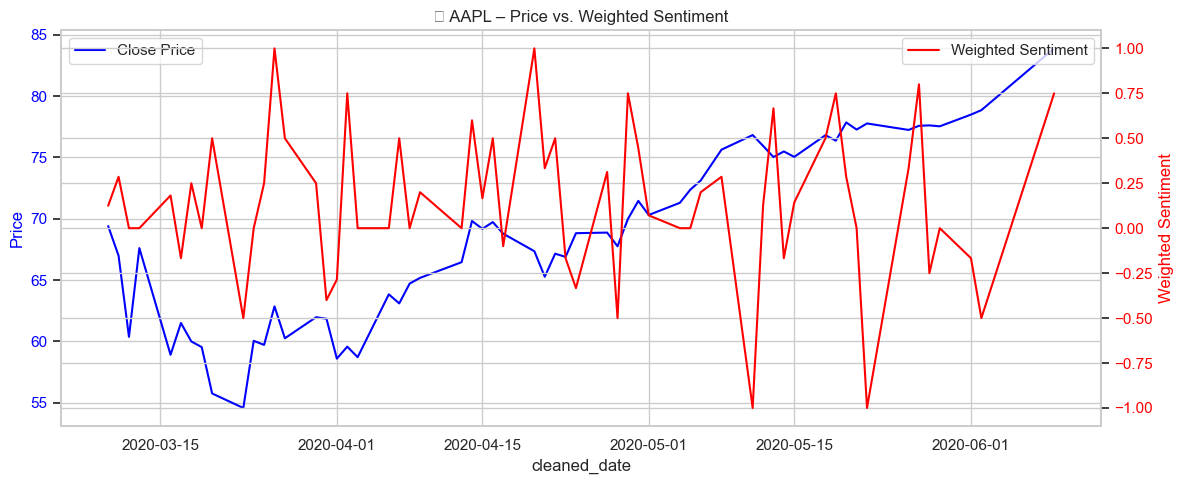

c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\signal_visualizer.py:139: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


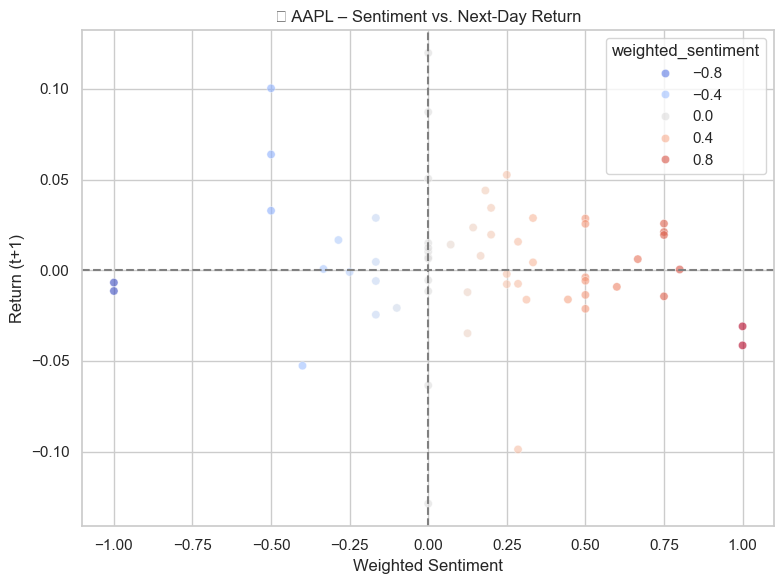

c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\signal_visualizer.py:225: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\stock-market-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


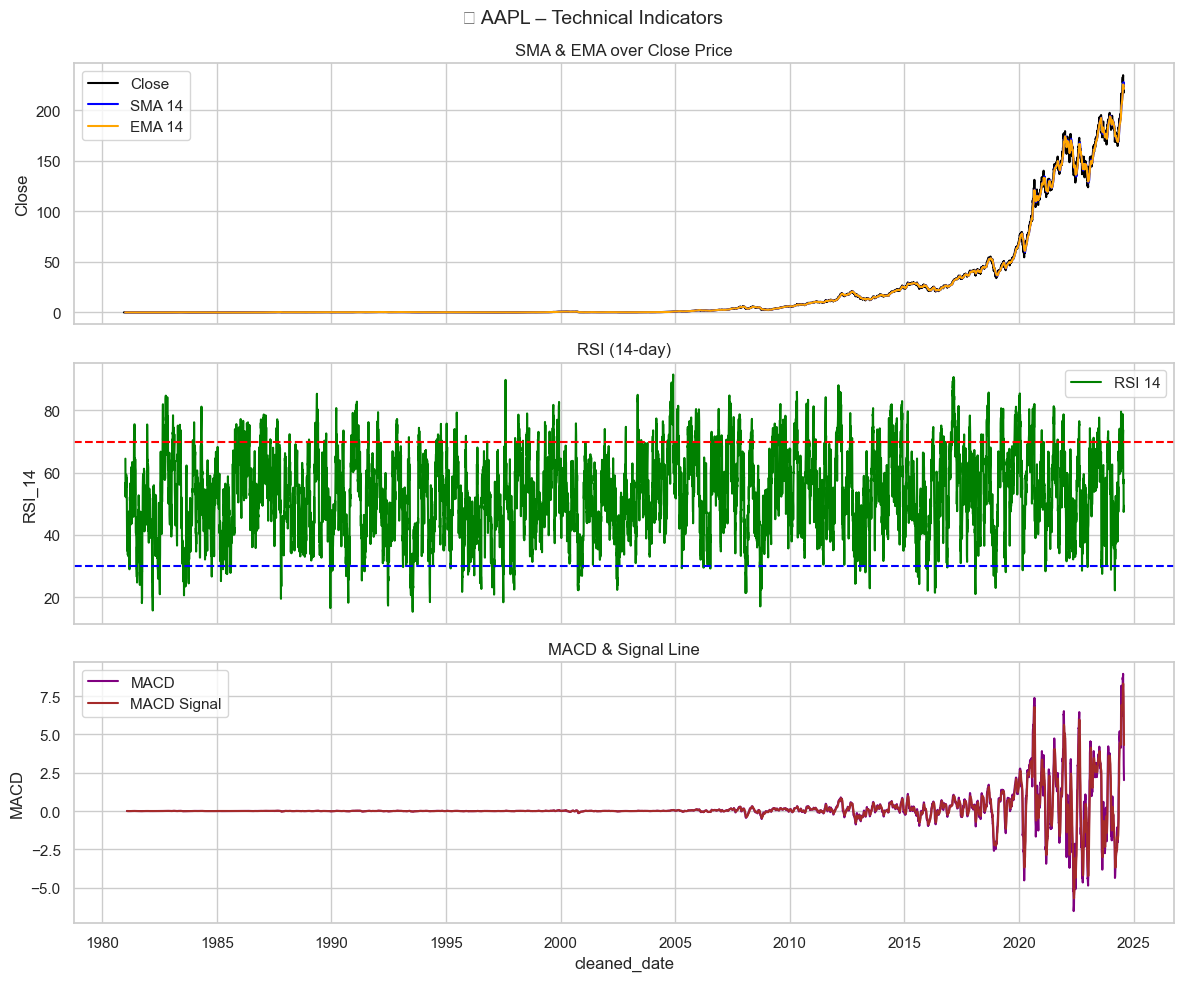

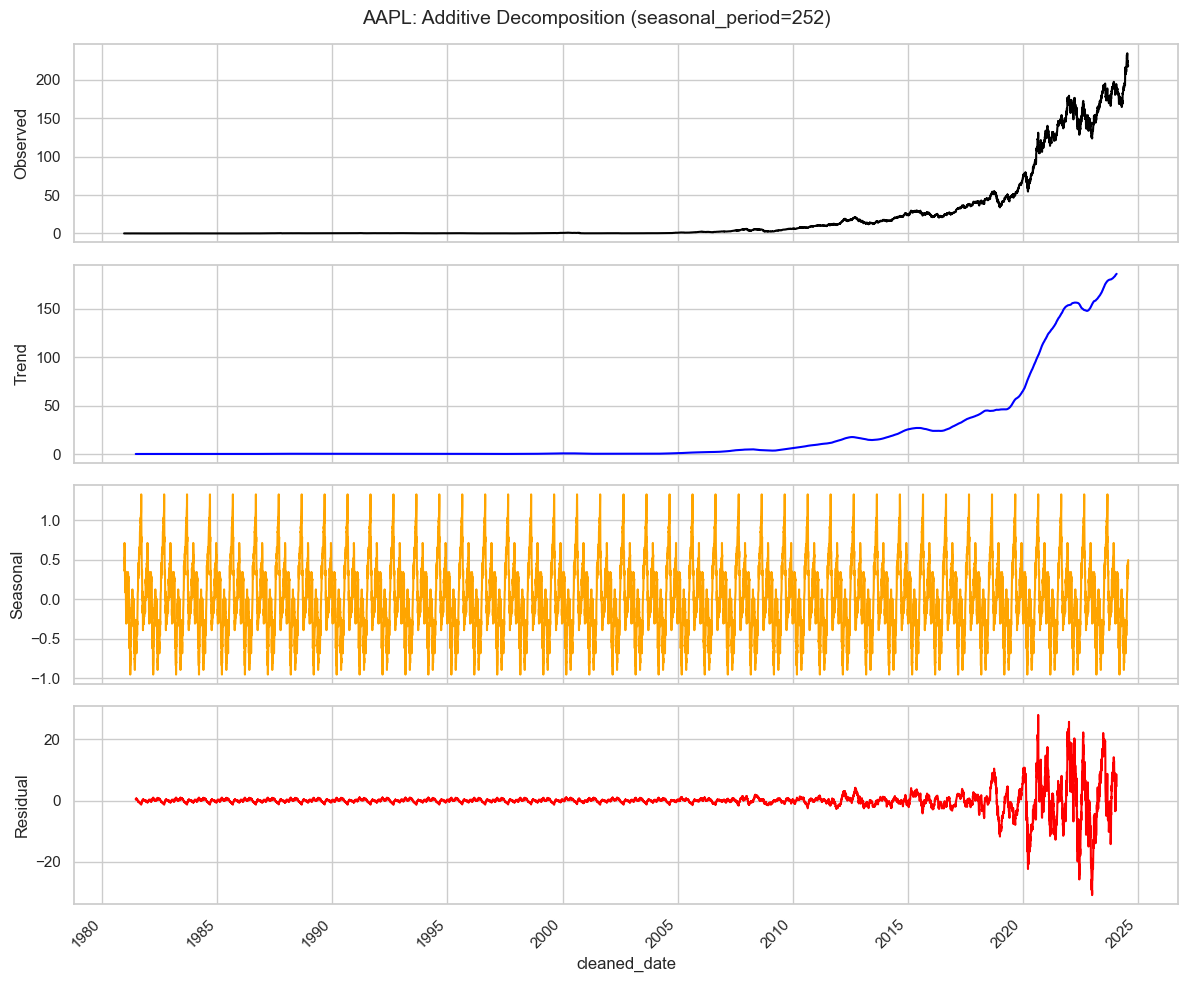

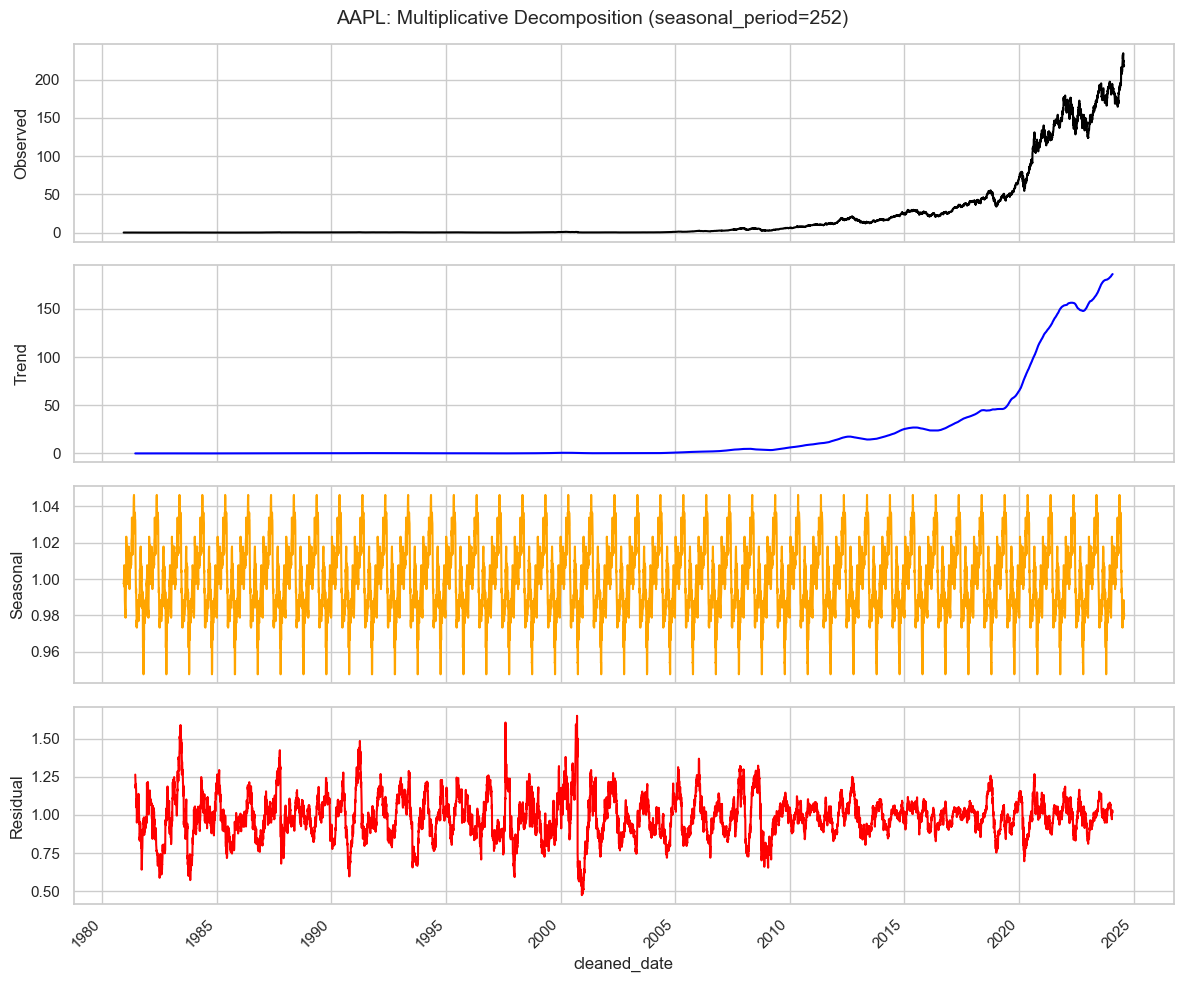

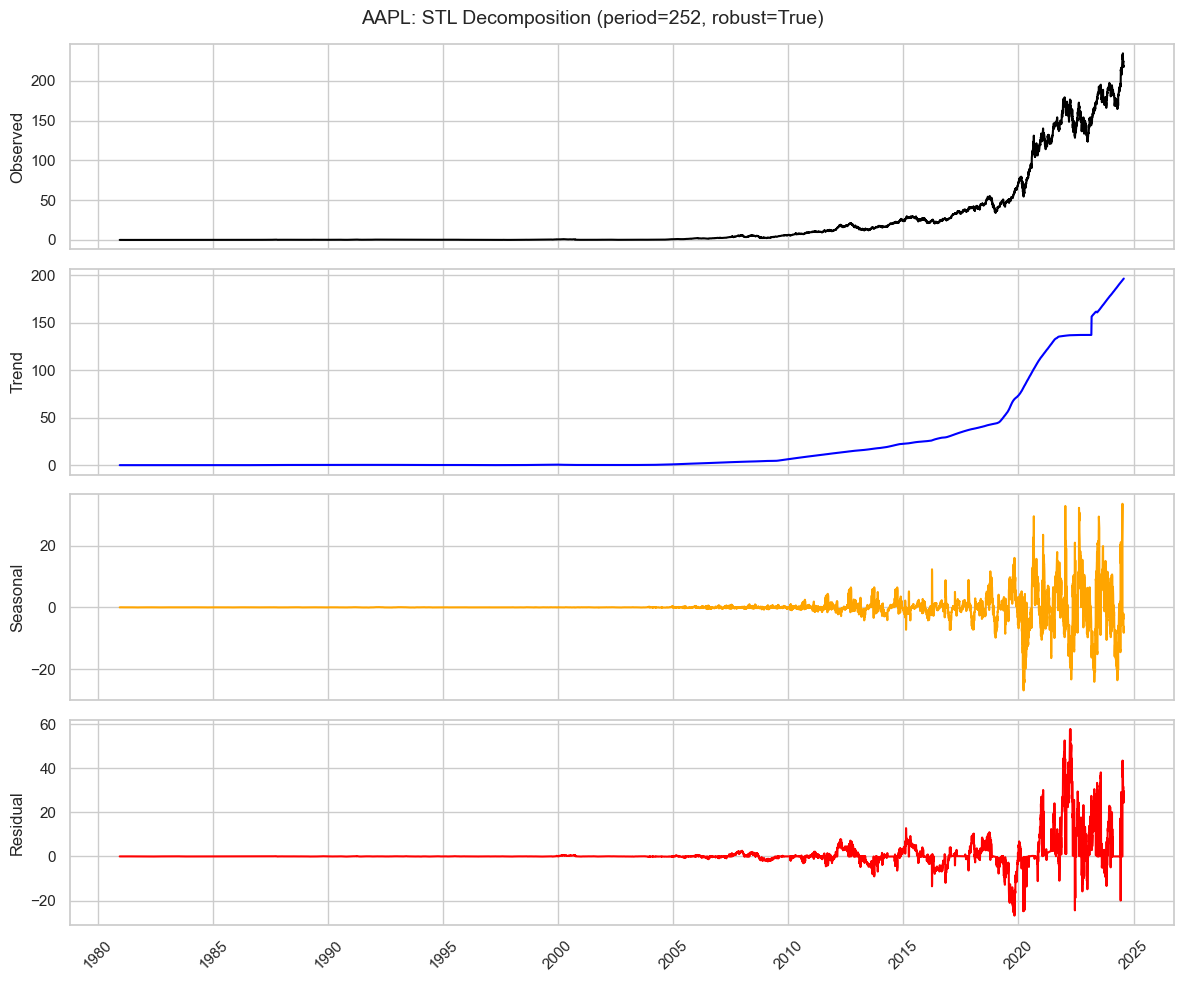

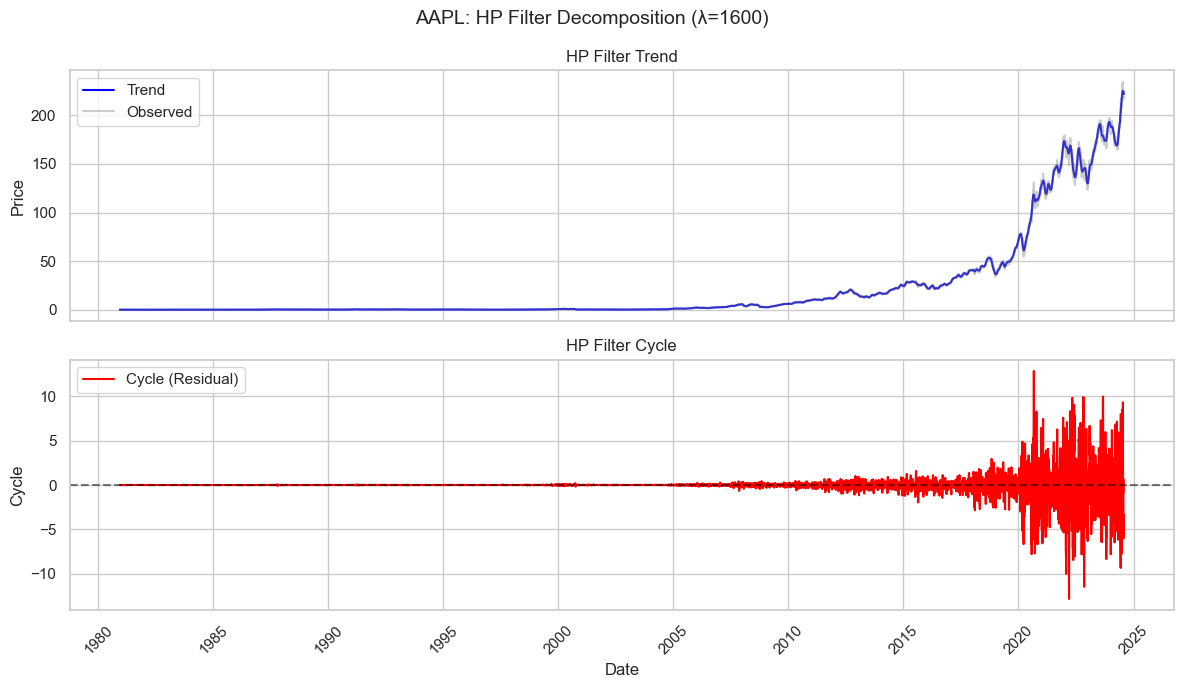

In [10]:
# ------------------------------------------------------------------------------
# 📊 Visualize Signals for Diagnostic Insights (With Pre-Checks for 'Close')
# ------------------------------------------------------------------------------

from src.signal_visualizer import SignalVisualizer

# 0) Fix merged‐column suffixes so that 'Close' appears in enriched_full_df
rename_map = {}
for col in ["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"]:
    if f"{col}_x" in enriched_full_df.columns:
        rename_map[f"{col}_x"] = col
enriched_full_df.rename(columns=rename_map, inplace=True)
to_drop = [c for c in enriched_full_df.columns if c.endswith("_y")]
if to_drop:
    enriched_full_df.drop(columns=to_drop, inplace=True)

# 1) Choose a stock ticker to analyze
selected_ticker = "AAPL"

# 2) Instantiate visualizers:
#    • full_vis    → for full-history TA + price
#    • aligned_vis → for sentiment-based plots (price + sentiment)
full_vis = SignalVisualizer(df=enriched_full_df)
aligned_vis = SignalVisualizer(df=final_df)

# 3) SENTIMENT-BASED PLOTS (use final_df, which should contain 'Close' & 'weighted_sentiment')
if selected_ticker not in final_df["ticker"].unique():
    print(
        f"⚠️ Ticker '{selected_ticker}' not found in final_df. Skipping sentiment-based plots."
    )
else:
    # 3a) Confirm 'Close' and 'weighted_sentiment' are in final_df
    missing_cols = [
        c for c in ["Close", "weighted_sentiment"] if c not in final_df.columns
    ]
    if missing_cols:
        print(
            f"⚠️ final_df missing columns {missing_cols}. Cannot plot sentiment vs. price."
        )
    else:
        # 3b) Filter to AAPL rows and check non-null values
        aapl_data = final_df[final_df["ticker"] == selected_ticker]
        if aapl_data["Close"].notna().sum() == 0:
            print(
                f"⚠️ No non-null 'Close' for '{selected_ticker}' in final_df. Skipping price plot."
            )
        elif aapl_data["weighted_sentiment"].notna().sum() == 0:
            print(
                f"⚠️ No non-null 'weighted_sentiment' for '{selected_ticker}'. Skipping sentiment plot."
            )
        else:
            # 3c) Plot sentiment vs. price
            aligned_vis.plot_sentiment_vs_price(ticker=selected_ticker)

            # 3d) Plot sentiment vs. next-day return (if available)
            if "forward_return_1d" in final_df.columns:
                if aapl_data["forward_return_1d"].notna().sum() > 0:
                    aligned_vis.plot_sentiment_return_scatter(ticker=selected_ticker)
                else:
                    print(
                        f"⚠️ No non-null 'forward_return_1d' for '{selected_ticker}'. Skipping scatter."
                    )
            else:
                print(
                    "⚠️ 'forward_return_1d' missing in final_df. Skipping sentiment-return scatter."
                )

# 4) TA-ONLY PLOTS (use enriched_full_df, which must contain 'Close')
if selected_ticker not in enriched_full_df["ticker"].unique():
    print(
        f"⚠️ Ticker '{selected_ticker}' not found in enriched_full_df. Skipping TA-only plots."
    )
else:
    # 4a) Confirm 'Close' is in enriched_full_df
    if "Close" not in enriched_full_df.columns:
        print(
            "⚠️ 'Close' missing in enriched_full_df. Cannot plot technical indicators."
        )
    else:
        # 4b) Filter to AAPL rows and check non-null 'Close'
        aapl_full = enriched_full_df[enriched_full_df["ticker"] == selected_ticker]
        if aapl_full["Close"].notna().sum() == 0:
            print(
                f"⚠️ No non-null 'Close' for '{selected_ticker}' in enriched_full_df. Skipping TA plot."
            )
        else:
            # 4c) Check that required TA columns exist
            ta_cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "MACD_signal"]
            missing_ta = [c for c in ta_cols if c not in enriched_full_df.columns]
            if missing_ta:
                print(
                    f"⚠️ Missing TA columns {missing_ta} in enriched_full_df. Skipping TA plot."
                )
            else:
                full_vis.plot_technical_indicators(ticker=selected_ticker)

    # 4d) Price decomposition (need at least ~504 rows for seasonal methods)
    aapl_full = enriched_full_df[enriched_full_df["ticker"] == selected_ticker]
    n_points = aapl_full.shape[0]
    if n_points >= 504:
        full_vis.plot_price_decomposition(
            ticker=selected_ticker, model="additive", freq=252
        )
        full_vis.plot_price_decomposition(
            ticker=selected_ticker, model="multiplicative", freq=252
        )
        full_vis.plot_STL_decomposition(ticker=selected_ticker, period=252, robust=True)
    else:
        print(
            f"⚠️ Only {n_points} rows for '{selected_ticker}'. Need ≥504 for full decomposition. Skipping."
        )

    # 4e) HP filter (requires at least one row)
    if n_points > 0:
        full_vis.plot_HP_filter(ticker=selected_ticker, lamb=1600)
    else:
        print(
            f"⚠️ No data for '{selected_ticker}' in enriched_full_df. Skipping HP filter."
        )